<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/NAT_BANK_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab-env --upgrade -q
import colab_env
!pip install uv -q

In [ ]:
!uv pip install "nvidia-nat[all]"

   NVIDIA NAT • FULL CORRECTED BANKING SIMULATION
[TX-100] **Transaction Log Entry: TX-100**

**Transaction Status:** FLAG_FOR_REVIEW

**Reason for Flag:** High Risk Fraud Pattern - HIGH_VELOCITY

**Transaction Amount:** $7853.41

**Recovery Action:** Auto-Recovery SMS Sent: True

**Next Steps:**

1. Review transaction details for potential fraud indicators.
2. Verify customer information and account activity.
3. Determine the validity of the transaction and take necessary actions to resolve the issue.

**Log Entry Timestamp:** [Current Date and Time]

**Logged by:** [Your Name]

**Transaction Type:** [Type of Transaction, e.g., Card Not Present, Online Payment, etc.]

[TX-101] **Transaction Log Update**

Transaction ID: TX-101
Transaction Status: APPROVED
Transaction Amount: $787.62
Risk and Financial Checks: PASSED
Reason for Approval: All risk and financial checks were successfully completed.

**Internal Log Entry:**

Date: [Current Date]
Time: [Current Time]
User ID: [User ID of th

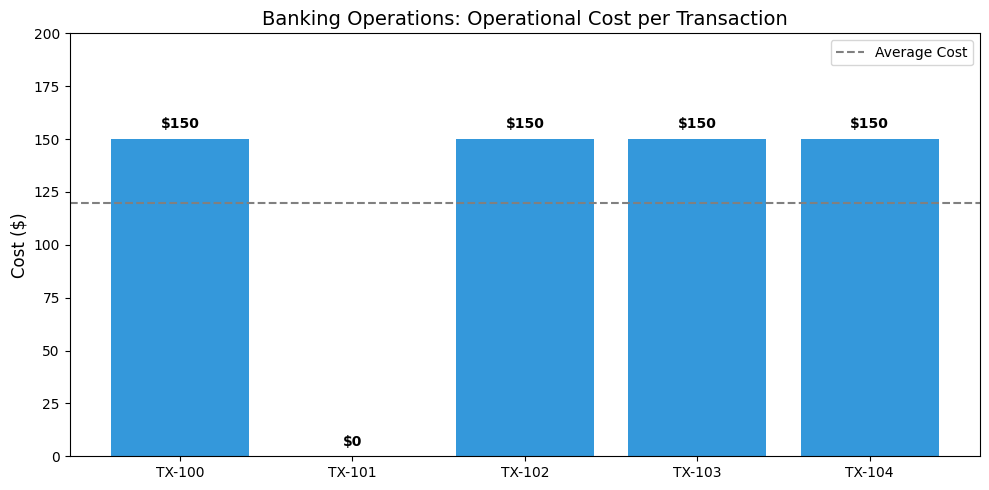

In [13]:
import asyncio
import random
import os
import getpass
from typing import Dict, Any
from openai import AsyncOpenAI
import nest_asyncio
import matplotlib.pyplot as plt
from pydantic import Field

# Required for execution in Jupyter/Colab environments
nest_asyncio.apply()

from nat.cli.register_workflow import register_function
from nat.data_models.function import FunctionBaseConfig
from nat.cli.type_registry import GlobalTypeRegistry

# 1. Setup Environment
try:
    # Clear registry to avoid duplicate function errors during re-runs
    GlobalTypeRegistry.get()._registered_functions.clear()
except Exception:
    pass

# Ensure API Key is available
if "NVIDIA_API_KEY" not in os.environ:
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter your NVIDIA API key: ")

client = AsyncOpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key=os.environ["NVIDIA_API_KEY"]
)

# 2. Banking Data Models (Pydantic)
class FraudInput(FunctionBaseConfig, name="fraud_input"):
    tx_id: str = Field(..., description="Transaction Identifier")

class ComplianceInput(FunctionBaseConfig, name="compliance_input"):
    customer_id: str = Field(..., description="Unique Customer ID")

class LoyaltyInput(FunctionBaseConfig, name="loyalty_input"):
    customer_id: str = Field(..., description="Unique Customer ID")

class CreditInput(FunctionBaseConfig, name="credit_input"):
    tx_id: str = Field(..., description="Transaction Identifier")
    amount: float = Field(..., description="Transaction Amount")
    is_vip: bool = Field(default=False, description="Whether customer has VIP status")

class LiquidityInput(FunctionBaseConfig, name="liquidity_input"):
    currency: str = Field(..., description="Currency Code (USD, EUR, etc)")

class RecoveryInput(FunctionBaseConfig, name="recovery_input"):
    tx_id: str = Field(..., description="Transaction ID")
    reason: str = Field(..., description="Reason for flag")

class CostInput(FunctionBaseConfig, name="cost_input"):
    tx_id: str = Field(..., description="Transaction ID")
    decision: str = Field(..., description="Final decision (APPROVE, FLAG, REJECT)")
    tx_amount: float = Field(default=0.0)

class RefinerInput(FunctionBaseConfig, name="refiner_input"):
    decision: str = Field(..., description="Final Decision")
    reason: str = Field(..., description="Reasoning for decision")
    tx_id: str = Field(..., description="Transaction ID")
    amount: float = Field(default=0.0)

# 3. Specialized Logic Agents
@register_function(config_type=FraudInput)
async def register_fraud(config, builder):
    async def logic(input_data):
        status = random.choice(["SAFE", "SUSPICIOUS", "HIGH_VELOCITY"])
        return {"status": status, "risk_level": "HIGH" if status == "HIGH_VELOCITY" else "LOW"}
    yield logic

@register_function(config_type=ComplianceInput)
async def register_compliance(config, builder):
    async def logic(input_data):
        status = random.choice(["CLEARED", "WATCHLIST", "EXPIRED_ID"])
        return {"status": status}
    yield logic

@register_function(config_type=LoyaltyInput)
async def register_loyalty(config, builder):
    async def logic(input_data):
        # Simulate check for VIP status
        return {"is_vip": random.choice([True, False]), "years_active": random.randint(1, 10)}
    yield logic

@register_function(config_type=CreditInput)
async def register_credit(config, builder):
    async def logic(input_data):
        # VIPs receive a higher possible credit ceiling
        max_limit = 15000 if input_data.is_vip else 5000
        limit = random.randint(1000, max_limit)
        return {"approved": input_data.amount <= limit, "limit": limit}
    yield logic

@register_function(config_type=LiquidityInput)
async def register_liquidity(config, builder):
    async def logic(input_data):
        return {"reserve_ready": random.choice([True, False])}
    yield logic

@register_function(config_type=RecoveryInput)
async def register_recovery(config, builder):
    async def logic(input_data):
        # Simulate sending an automated customer notification
        return {"sent": True, "message": f"Security Alert for {input_data.tx_id}: {input_data.reason}"}
    yield logic

@register_function(config_type=CostInput)
async def register_cost(config, builder):
    async def logic(input_data):
        # Define operational costs per decision type
        impact_map = {"APPROVE": 0, "FLAG_FOR_REVIEW": 150, "REJECT": 50}
        total = impact_map.get(input_data.decision, 0)
        return {"operational_cost": int(total)}
    yield logic

@register_function(config_type=RefinerInput)
async def register_refiner(config, builder):
    async def logic(input_data):
        # Generate a professional audit log using LLM
        response = await client.chat.completions.create(
            model="meta/llama-3.1-8b-instruct",
            messages=[
                {"role": "system", "content": "You are a professional Banking Operations Bot. Summarize the transaction status for the internal log."},
                {"role": "user", "content": f"TX {input_data.tx_id}: {input_data.decision} for ${input_data.amount:.2f} due to {input_data.reason}."}
            ],
            temperature=0.1
        )
        return {"notification": response.choices[0].message.content}
    yield logic

# 4. The Orchestrator
async def run_banking_ops(tx_id: str, amount: float, customer_id: str):
    async with register_fraud(None, None) as fraud_logic, \
               register_compliance(None, None) as comp_logic, \
               register_loyalty(None, None) as loyalty_logic, \
               register_credit(None, None) as credit_logic, \
               register_liquidity(None, None) as liq_logic, \
               register_recovery(None, None) as recovery_logic, \
               register_cost(None, None) as cost_logic, \
               register_refiner(None, None) as refiner_logic:

        # Parallel risk and status screening
        f, c, loy, l = await asyncio.gather(
            fraud_logic(FraudInput(tx_id=tx_id)),
            comp_logic(ComplianceInput(customer_id=customer_id)),
            loyalty_logic(LoyaltyInput(customer_id=customer_id)),
            liq_logic(LiquidityInput(currency="USD"))
        )

        # Dependent credit evaluation using VIP status from loyalty check
        cr = await credit_logic(CreditInput(tx_id=tx_id, amount=amount, is_vip=loy["is_vip"]))

        # Decision Tree Logic
        if f["risk_level"] == "HIGH":
            decision, reason = "FLAG_FOR_REVIEW", f"High Risk Fraud Pattern: {f['status']}"
        elif f["status"] == "SUSPICIOUS" and amount > 2000:
            decision, reason = "FLAG_FOR_REVIEW", "Suspicious pattern detected on mid-value transaction"
        elif c["status"] != "CLEARED":
            decision, reason = "REJECT", f"Compliance issue: {c['status']}"
        elif not cr["approved"]:
            # VIPs are flagged for review (white-glove) instead of being auto-rejected
            decision = "FLAG_FOR_REVIEW" if loy["is_vip"] else "REJECT"
            reason = f"Insufficient Limit (${cr['limit']}). VIP status: {loy['is_vip']}"
        elif not l["reserve_ready"]:
            decision, reason = "FLAG_FOR_REVIEW", "Currency Liquidity Constraint"
        else:
            decision, reason = "APPROVE", "All risk and financial checks passed"

        # Automated Recovery trigger if flagged
        rec_info = ""
        if decision == "FLAG_FOR_REVIEW":
            rec = await recovery_logic(RecoveryInput(tx_id=tx_id, reason=reason))
            rec_info = f" (Auto-Recovery SMS Sent: {rec['sent']})"

        # Finalize impact analysis and professional summary
        cost_rep = await cost_logic(CostInput(tx_id=tx_id, decision=decision, tx_amount=amount))
        final = await refiner_logic(RefinerInput(decision=decision, reason=reason + rec_info, tx_id=tx_id, amount=amount))

        return {"id": tx_id, "cost": cost_rep["operational_cost"], "summary": final["notification"]}

# 5. Visualization Component
def plot_operational_impact(results_list):
    ids = [r['id'] for r in results_list]
    costs = [r['cost'] for r in results_list]

    # Color mapping: Green for Approve, Blue for Flag/Manual, Red for Reject
    colors = ['#2ecc71' if c == 0 else '#3498db' if c > 50 else '#e74c3c' for c in costs]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(ids, costs, color=colors)
    plt.axhline(y=sum(costs)/len(results_list), color='gray', linestyle='--', label='Average Cost')

    plt.title('Banking Operations: Operational Cost per Transaction', fontsize=14)
    plt.ylabel('Cost ($)', fontsize=12)
    plt.ylim(0, max(costs) + 50)
    plt.legend()

    # Add cost labels to bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'${yval}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('banking_ops_impact.png')

# 6. Simulation Engine
async def simulate_banking_day(count=5):
    random.seed(42) # Ensuring reproducible simulation results
    print("="*60 + "\n   NVIDIA NAT • FULL CORRECTED BANKING SIMULATION\n" + "="*60)

    # Launching asynchronous tasks for transaction processing
    tasks = [run_banking_ops(f"TX-{100+i}", random.uniform(500, 12000), f"CUST-{50+i}") for i in range(count)]
    results_list = await asyncio.gather(*tasks)

    # Printing professional log outputs
    for r in results_list:
        print(f"[{r['id']}] {r['summary']}\n")

    total_impact = sum(r['cost'] for r in results_list)
    print("-" * 60 + f"\nTotal Operational Review Cost: ${total_impact:,}\n" + "-" * 60)

    # Generate the visual impact report
    plot_operational_impact(results_list)
    return results_list

if __name__ == "__main__":
    results = await simulate_banking_day(5)